# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#Прочитаем файл и посмотрим как выглядит таблица
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
#Просмотрим колонки более детально
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

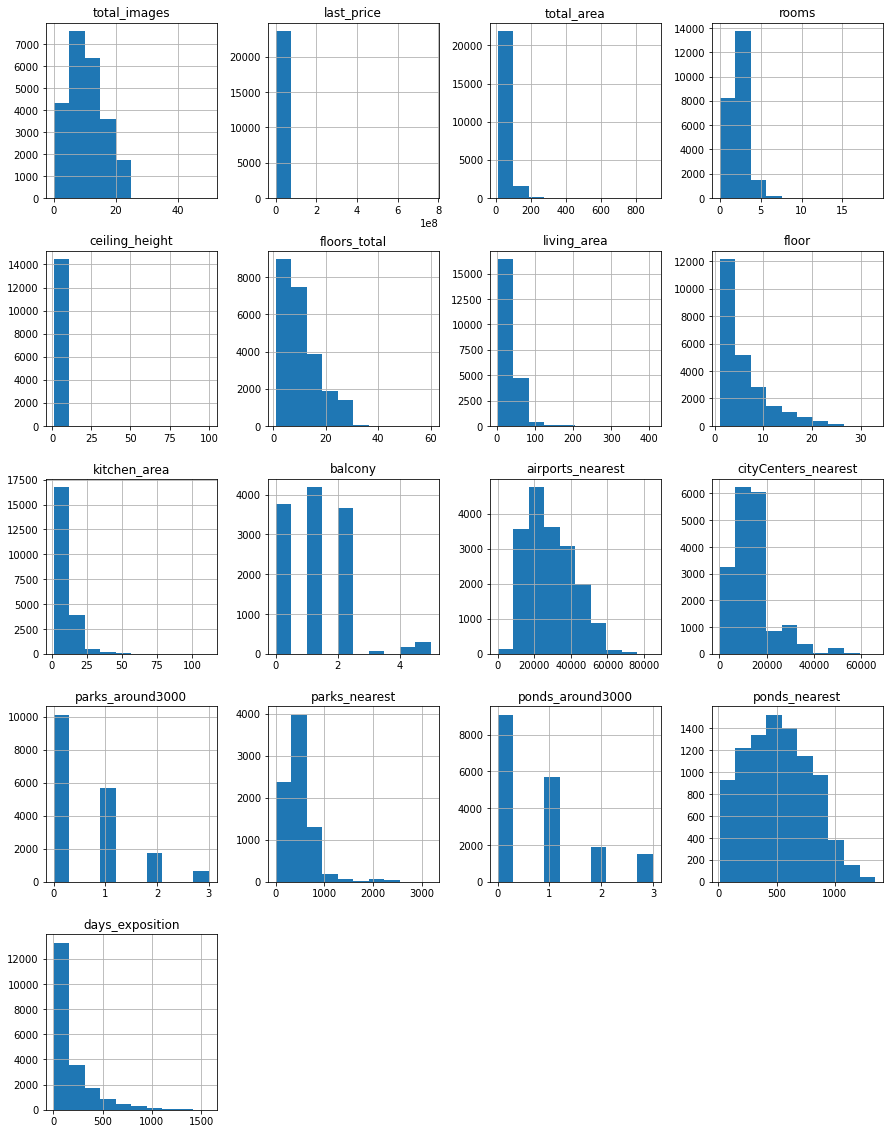

In [3]:
# Строим гистрограммы для каждой числовой колонки
df.hist(figsize=(15,20))
plt.show()

 Предварительный вывод из имеющейся информации:
 - Заметим, во многих столцах в графе "Non-Null Count" разные значения - свидетельство пропусков. Пропуски во многих графах могут быть связаны с человеческим фактором, либо с техническими ошибками. Присутствуют графы, которые заполнялись человеком и графы, которые заполнялись автоматически.
 - Не все столбцы имеют оптимальный для своего описания тип:
   - first_day_exposition необходим формат даты
   - floors_total, balcony, days_exposition необходим тип целых чисел
   - is_apartment необходим булевый формат
 - Колонка cityCenters_nearest имеет нелучший стиль, но при этом читаемо, понятен смысл - менять не будем.
 - По гистограммам видим, к примеру, колонки kitchen_area и ceiling_height имеют редкие и аномальные данные: 100 площади кухни в квадратных метрах и 100 высоты потолка в метрах. Эти примеры заставляют задуматься о точности и качестве предоставленных данных.

### Выполните предобработку данных

In [4]:
#Опеределим количество явных дубликатов
df.duplicated().sum()

0

In [5]:
#Изучим количество пустых значениях по каждой колонке
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Высота потолков

In [6]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

По описанию графы и ее гистрограмме, считаю лучшим вариантом замены пропущенных значений медианой.

In [7]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

#### Количество этажей в доме

Пропущенные значения в количестве этажей невозможно восстановить или заменить на какие-то значения, не зная, где находится дом. В таблице таких значений всего 86 - предлагаю удалить пропуски.

In [8]:
df = df.dropna(subset=['floors_total'])

#### Апартаменты

In [9]:
#Убедимся, что в графе is_apartment могут быть только 2 значения
df['is_apartment'].unique()

array([nan, False, True], dtype=object)

Жилая площадь может быть апартаментами или ими не быть. Скорее всего, поле не являлось обязательным и для квартир, которые не являлись апартаментами игнорировалось данное поле. Заменим пропущенные значения на False.

In [10]:
df['is_apartment'] = df['is_apartment'].fillna(False)

#### Балкон

In [11]:
#Определим, какие значения бывает в поле с балконом
df['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Похожая ситуация как с апартаментами. Если поле не указали, скорее всего, балкона в квартире нет. Заменим пропущенные значения на 0

In [12]:
df['balcony'] = df['balcony'].fillna(0)

#### Населенный пункт

Пропущенные значения в графе с местоположением квартиры невозможно заменить, не зная адрес, таких значений 48 - удалим пропуски в этой графе и посмотрим какие присутствуют уникальные значения.

In [13]:
df = df.dropna(subset=['locality_name'])

#Посмотрим, какие населенные пункты представлены
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

В таблице присутствуют много похожих значений, которые мы можем подвести под единый формат без потери смысловой нагрузки.
 - Буквы 'е' и 'ё' в слове посёлок. Поменяем все на 'е' - так удобнее и более привычно
 - городской поселок и поселок гордского типа. Оставим полное наименование
 - садовое товарищество и садоводческое некоммерческое товарищество. Оставим полное наименование
 - посёлок станции и посёлок при железнодорожной станции. Оставим полное наименование

In [14]:
#Приведем похожие значения под один формат
df['locality_name'] = df['locality_name'].replace('посёлок','поселок',regex=True)
df['locality_name'] = df['locality_name'].replace('городской поселок', 'поселок городского типа',regex=True)
df['locality_name'] = df['locality_name'].replace('садовое товарищество', 'садоводческое некоммерческое товарищество',regex=True)
df['locality_name'] = df['locality_name'].replace('посёлок станции', 'посёлок при железнодорожной станции', regex=True)

**Меняем типы в столбцах, в которых сейчас можем произвести замену**

In [15]:
df['balcony'] = df['balcony'].astype('int')
df['floors_total'] = df['floors_total'].astype('int')

In [16]:
#Обратимся к описанию
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  int64  
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23565 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Итог:
1. Много "нечистых" данных, которые невозможно восполонить без обращения к сторонним источникам. Можно порекомендовать коллегам, которые предоставили данные, ввести в некоторые строки фильтры/выпадающие списки для упрощенрия анализа.


2. Комментарии по некоторым колонкам:
 - first_day_exposition заменим в следующем этапе и приведем в более корректный формат.
 - living_area, kitchen_area, airports_nearest, cityCenters_nearest,parks_around3000, parks_nearest, ponds_around3000, ponds_nearest,days_exposition - Эти поля не представляется возможным заменить без обращения за дополнительной информацией. Было принято решение не заменять пропуски вообще.
 - days_exposition, parks_around3000, ponds_around3000 - данные поля предпочительнее будут выглядеть в формате целых чисел, но за присутсвием пропусков, пока оставим без изменений.

### Добавьте в таблицу новые столбцы

#### Стоимость одного квадратного метра

In [17]:
#Добавляем столбец и округляем до 2х занков
df['price_per_mtr'] = (df['last_price']/df['total_area']).round(2)

Переведем формат времени в более корректный тип. Добавим 3 новых столбца:
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
- месяц публикации объявления
- год публикации объявления

In [18]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%S:%M:%H')
df['published_day'] = df['first_day_exposition'].dt.weekday
df['published_month'] = df['first_day_exposition'].dt.month
df['published_year'] = df['first_day_exposition'].dt.year

#### Тип этажа

Добавим дополнительный столбец в таблицу, в котором укажем тип этажа:
- первый
- последний
- другой

In [19]:
#Ресетнем индексы, чтобы избежать ошибок в работе цикле
df = df.reset_index(drop=True)
#Создаем цикл в котором будут перебираться данные и добавляться в таблицу по заданным значениям
for i in range(len(df)):
    if df.loc[i, 'floor'] == 1:
        df.loc[i, 'floor_type'] = 'первый'
    elif df.loc[i, 'floor'] == df.loc[i, 'floors_total']:
        df.loc[i, 'floor_type'] = 'последний'
    else:
        df.loc[i, 'floor_type'] = 'другой'

#### Расстояние до центра города в километрах

In [20]:
df['city_centre_km'] = df['cityCenters_nearest'] / 1000
df['city_centre_km'] = df['city_centre_km'].round()

### Проведите исследовательский анализ данных

Для продолжения анализа детальнее рассмотрим ряд параметров.

#### 1. Общая площадь

In [21]:
df['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Судя по описанию колонки и визуализации на гистограмме - значений после 200 мало, а есть и единичные выбросы аномально больших значений. Возьмем выборку до 200, сначала узнав сколько таких значений.

In [22]:
#Проверяем количество значений
len(df.query('total_area >= 200'))

230

Значений 230, предлагаю их удалить и изучить параметр более детально. Предположительно, могут быть очень маленькие по метражу квартиры, оставим минимальные значения без изменений.

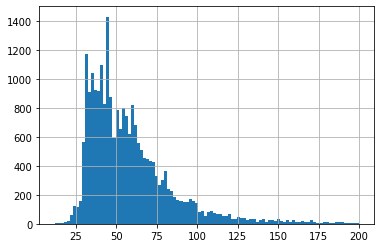

In [23]:
#Сортируем
df = df.query('total_area <= 200')
#Изучим новый график
df['total_area'].hist(bins=100)
plt.show()

In [24]:
#Разделим столбец на 5 равных интервалов
pd.qcut(df['total_area'], 5)

0         (74.0, 200.0]
1          (37.4, 45.7]
2          (45.7, 57.8]
3         (74.0, 200.0]
4         (74.0, 200.0]
              ...      
23560     (74.0, 200.0]
23561      (57.8, 74.0]
23562      (45.7, 57.8]
23563     (74.0, 200.0]
23564    (11.999, 37.4]
Name: total_area, Length: 23339, dtype: category
Categories (5, interval[float64]): [(11.999, 37.4] < (37.4, 45.7] < (45.7, 57.8] < (57.8, 74.0] < (74.0, 200.0]]

Вывод: больше всего квартир в зависимости от общей площади представлены в промежутке от 27 до 60 квадратных метров. Присутствуют и квартиры, которые можно назвать сегментом выше среднего и премиальным - в промежутке от 74 до 200 квадратных метров (составляет 20% из выборки).

#### Жилая площадь

In [25]:
df['living_area'].describe()

count    21502.000000
mean        33.248079
std         17.368396
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

Видны выбивающиеся значения по гистограмме. Выберем интервал от 10 до 100 квардратных метров.

In [26]:
len(df.query('living_area >= 100 and living_area <= 10'))

0

Значений мало - удаляем.

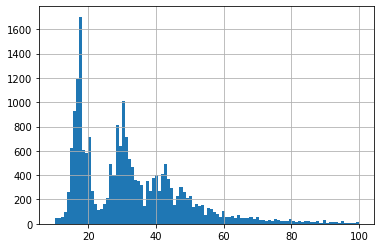

In [27]:
df = df[(df['living_area'].isna()) | ((df['living_area'] <= 100) & (df['living_area'] >=10))]
df['living_area'].hist(bins=100)
plt.show()

Вывод: представлены квартиры в большинстве своем имеют площадь жилой зоны около 17 и 30 квадратных метров, также существует квартиры "премиум" сегмента с 60 до 100 метров. Пики обусловлены квартирами-студиями и однокомнатными квартирами.

#### Площадь кухни

In [28]:
df['kitchen_area'].describe()

count    20956.000000
mean        10.309088
std          5.291097
min          1.300000
25%          7.000000
50%          9.000000
75%         11.800000
max         93.200000
Name: kitchen_area, dtype: float64

Размер кухни в 1.3 и квадрата выглядит неправдоподобно, как и 93. Рассмотримм промежуток с 3 до 30, с учетом пропущенных значений.

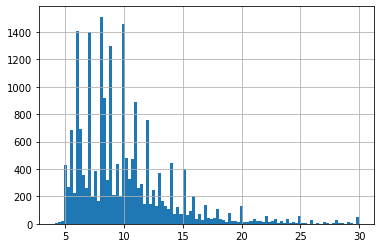

In [29]:
df = df[(df['kitchen_area'].isna()) | ((df['kitchen_area'] <= 30) & (df['kitchen_area'] > 4))]
df['kitchen_area'].hist(bins=100)
plt.show()

Судя по графику, размер кухни может быть абсолютно разный больше всего квартир имеют размеры 7-10 квадратов. Выделим, что существуют "большие" кухни (>15 квадратных метров), скорее всего это кухни-гостинные.

#### Цена

In [30]:
df['last_price'].describe()

count    2.284500e+04
mean     5.712200e+06
std      4.752611e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.570000e+06
75%      6.500000e+06
max      1.240000e+08
Name: last_price, dtype: float64

Так как цены имеют большие значения, для простоты и наглядности добавим столбец с сокращенной стоимостью.

In [31]:
df['last_price_new'] = df['last_price'] // 100000

Уберем из таблицы сильно выбивающиейся значения, рассмотрим только диапазон до 20кк

In [32]:
len(df.query('last_price_new >= 200'))

368

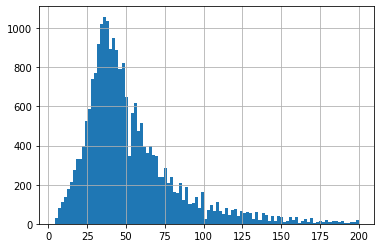

In [33]:
df = df.query('last_price_new <= 200')
df['last_price_new'].hist(bins=100)
plt.show()

Вывод: в среднем стоимость квартиры колеблется в диапозоне от 3кк до 5кк

#### Количество комнат

In [34]:
df['rooms'].describe()

count    22489.000000
mean         1.985815
std          0.943260
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

Отсортируем, удалим значения 0 и больше 5

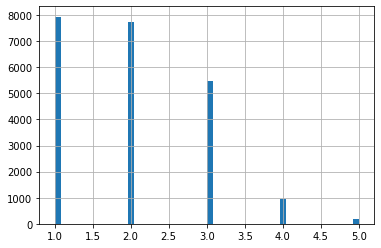

In [35]:
df = df.query('rooms < 6 and rooms > 0')
df['rooms'].hist(bins=50)
plt.show()

Вывод: самое большое количество квартир имеют от 1 до 3 комнат. Квартиры с более чем 3 комнатами встречаются очень редко.

#### Высота потолка

In [36]:
df['ceiling_height'].describe()

count    22274.000000
mean         2.710617
std          0.999995
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [37]:
#Проверим самые большие значения, так как можем скорректировать некоторые значения самостоятельно
df['ceiling_height'].sort_values(ascending=False).head(30)

22739    100.0
22211     32.0
3134      32.0
21256     27.5
5219      27.0
21700     27.0
20364     27.0
22807     27.0
17756     27.0
5777      27.0
10713     27.0
5641      26.0
18442     25.0
4621      25.0
11221     25.0
14298     25.0
353       25.0
9334      25.0
6213      25.0
5051      24.0
20393     22.6
17399     20.0
14975     14.0
22184     10.3
5833       8.3
15656      8.0
3459       8.0
17345      8.0
12557      5.3
1049       5.0
Name: ceiling_height, dtype: float64

Предположим, аномальные значения (2 значные числа) связаны с человеческой ошибкой. Передвинем дробную часть на 1 знак влево. Значение 100 единичное и не понятна его природа - удаляем.

In [38]:
df = df.reset_index(drop=True)
for i in range(len(df)):
    if df.loc[i, 'ceiling_height'] > 10:
        df.loc[i, 'ceiling_height'] /= 10

df = df.query('ceiling_height < 10')


Для анализа выберем диапазон значений с 2 до 4 метров.

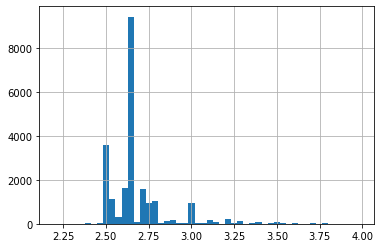

In [39]:
df = df.query('ceiling_height < 4 and ceiling_height > 2')
df['ceiling_height'].hist(bins=50)
plt.show()

Вывод: больше всего представлено квартир с высотой потолка от 2.5 до 2,75 метров.

#### Тип этажа

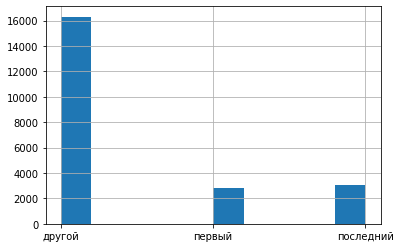

In [40]:
df['floor_type'].hist(bins=10)
plt.show()

Вывод: больше всего квартир представлены ни на первом, ни на последнем этаже.

#### Общее количество этажей

In [41]:
df['floors_total'].describe()

count    22198.000000
mean        10.728084
std          6.604474
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Выделим и удалим аномальные значения, возьмем выборку домов, в которых до 30 этажей.

In [42]:
len(df.query('floors_total > 30'))

29

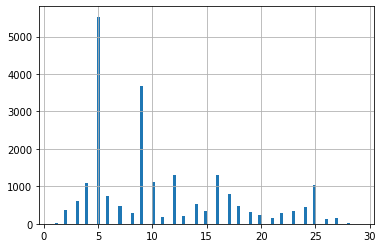

In [43]:
df = df.query('floors_total < 30')
df['floors_total'].hist(bins=100)
plt.show()

Вывод: подавляющее количество домов, в которых продаются квартиры имеют по 5 и 9 этажей.

#### Расстояние от центра города

In [44]:
df['city_centre_km'].describe()

count    16805.000000
mean        14.614162
std          8.580223
min          0.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: city_centre_km, dtype: float64

Напомним, что данное поле было заполнено системой автоматически. Не все значения были даны изначально, много пропусков, которые невозможно восстановить самостоятельно. Чтобы не уменьшать еще сильнее выборку, оставим данные диапазоны.

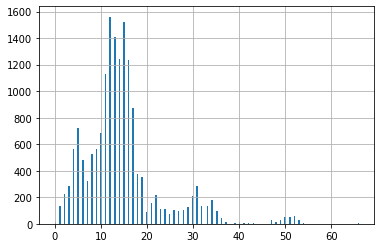

In [45]:
df['city_centre_km'].hist(bins=200)
plt.show()

Вывод: невозможно точно сказать как система определила где находится центр, город неравномерный. Больше всего представлены квартиры, находяшиеся на расстоянии 12-16 киломентров от центра

#### Расстояние до ближайшего парка

In [46]:
df['parks_nearest'].describe()

count    7251.000000
mean      493.636326
std       340.804577
min         1.000000
25%       289.000000
50%       456.000000
75%       616.500000
max      3190.000000
Name: parks_nearest, dtype: float64

Поступим аналогично **расстоянию до центра города**.

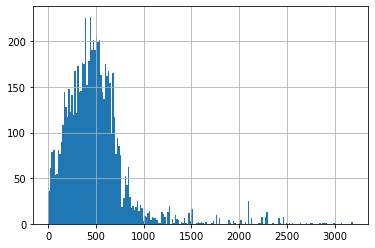

In [47]:
df['parks_nearest'].hist(bins=200)
plt.show()

Вывод: существует минимальное значение (1 метр), предположим, что такое возможно, как и факт ближайшего парка в 3 километра. Больше всего квартир представлено в диапазоне от 250 до 600 на расстоянии до ближайшего парка.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22169 entries, 0 to 22273
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22169 non-null  int64         
 1   last_price            22169 non-null  float64       
 2   total_area            22169 non-null  float64       
 3   first_day_exposition  22169 non-null  datetime64[ns]
 4   rooms                 22169 non-null  int64         
 5   ceiling_height        22169 non-null  float64       
 6   floors_total          22169 non-null  int64         
 7   living_area           20432 non-null  float64       
 8   floor                 22169 non-null  int64         
 9   is_apartment          22169 non-null  bool          
 10  studio                22169 non-null  bool          
 11  open_plan             22169 non-null  bool          
 12  kitchen_area          20245 non-null  float64       
 13  balcony         

**Изучим насколько быстро продавались квартиры**

In [49]:
df['days_exposition'].describe()

count    19324.000000
mean       176.812202
std        215.067393
min          1.000000
25%         44.000000
50%         93.000000
75%        225.000000
max       1580.000000
Name: days_exposition, dtype: float64

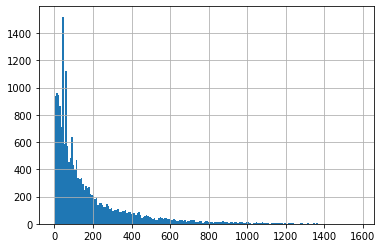

In [50]:
df['days_exposition'].hist(bins=200)
plt.show()

Разделим на 4 категорий, таким образом поделим на категории по скорости продажи.

In [51]:
pd.qcut(df['days_exposition'], 4)

0                    NaN
1           (44.0, 93.0]
2        (225.0, 1580.0]
3           (44.0, 93.0]
4          (93.0, 225.0]
              ...       
22269                NaN
22270       (44.0, 93.0]
22271                NaN
22272    (225.0, 1580.0]
22273                NaN
Name: days_exposition, Length: 22169, dtype: category
Categories (4, interval[float64]): [(0.999, 44.0] < (44.0, 93.0] < (93.0, 225.0] < (225.0, 1580.0]]

Вывод: большинство квартир продаются за первые полгода. Медиана скорости продажи - 100 дней, средняя скорость продажи - 182 дня. Разделим на 4 категории продаж:
- очень быстрая продажа (до 44 дней)
- быстрая продажа (от 45 до 99 дней)
- средняя продажа (от 100 до 232 дней)
- долгая продажа (дольше 233 дней)

**Определение факторов, влияющих на общую стоимость квартиры**

#### Общая площадь

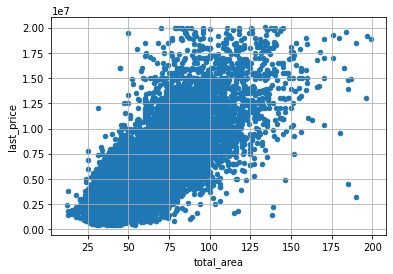

In [52]:
#Строим диаграмму расброса
df.plot.scatter(x='total_area', y='last_price', grid=True)
plt.show()

In [53]:
df['last_price'].corr(df['total_area'])

0.756406825512266

Вывод: по графику понятно - от общей площади квартиры прямо зависит и ее стоимость. ПО корреляции видна сильная положительная связь.

#### Жилая площадь

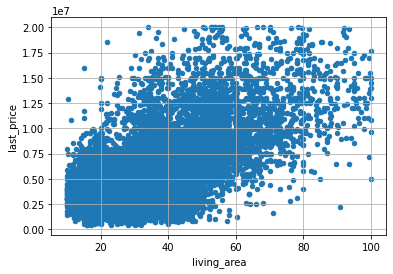

In [54]:
df.plot.scatter(x='living_area', y='last_price', grid=True)
plt.show()

In [55]:
df['last_price'].corr(df['living_area'])

0.6445533642690999

Вывод: ситуация такая же как и с общей площадью - чем выше жилая площадь, тем выше стоимость квартиры. Наблюдается умеренная положительная связь.

#### Площадь кухни

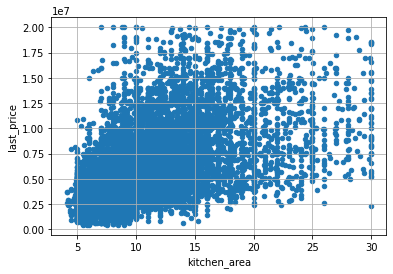

In [56]:
df.plot.scatter(x='kitchen_area', y='last_price', grid=True)
plt.show()

In [57]:
df['last_price'].corr(df['kitchen_area'])

0.5563091054107341

Вывод: Прямая зависимость - чем выше площадь кухни, тем выше стоимость квартиры, но корреляция меньше, чем в случае с общей и жилой площадью.

#### Количество комнат

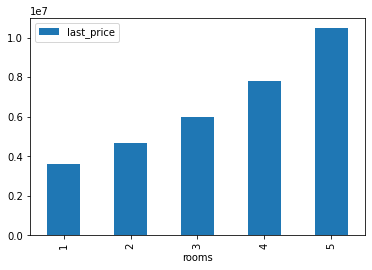

In [58]:
price_rooms = df.pivot_table(index = 'rooms', values = 'last_price', aggfunc='median').sort_values(by='last_price').reset_index()
price_rooms.plot.bar(x='rooms', y='last_price')
plt.show()

In [59]:
df['rooms'].corr(df['last_price'])

0.4742243860751841

Вывод: закономерно, чем выше количество комнат в квартире, тем выше будет ее стоимость.

#### Тип этажа

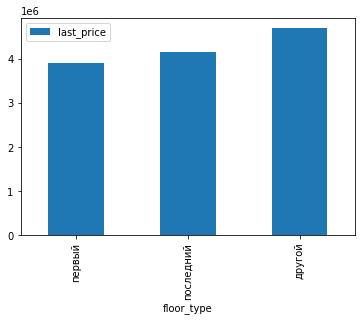

In [60]:
price_rooms = df.pivot_table(index = 'floor_type', values = 'last_price',aggfunc='median').sort_values(by='last_price').reset_index()
price_rooms.plot.bar(x='floor_type', y='last_price')
plt.show()

Вывод: склоняюсь, какая может быть причина пропости в значениях - маленький спроса на квартиры первого этажа(мало желающих жить на первом этаже), для удачнйо продажи прибегают к снижению стоимости. Примечательно, что на последнем этаже стоимость квартир тоже относительно невысокая в сравнении из категории "другой".

#### День размещения

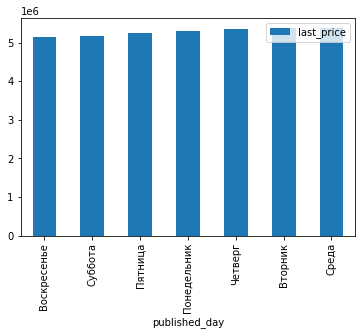

In [61]:
price_day = df.pivot_table(index = 'published_day', values = 'last_price').sort_values(by='last_price').reset_index()
price_day['published_day'] = price_day['published_day'].replace({0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'})
price_day.plot.bar(x='published_day', y='last_price')
plt.show()

Расброс не очень высокий, связываю это с погрешностью, думаю, чем больше будет выборка, тем более значения будут выровняться. В целом, спрос на покупку квартиры больше по четвергам, когда в выходные люди проедпочитают отдыхать, а не думать о таких масштабных покупках.

#### Месяц размещения

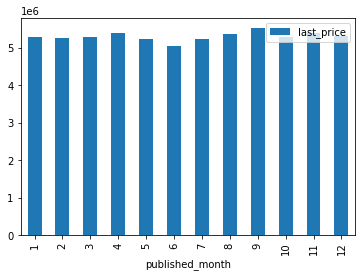

In [62]:
price_month = df.pivot_table(index = 'published_month', values = 'last_price').reset_index()
price_month.plot.bar(x='published_month', y='last_price')
plt.show()

Вывод: Связываю такие колебания с сезонностью. Летом люди больше обеспокоены отпуском и качественным отдыхом, когда с сентября люди возвращаются и задумываются о покупке жилья, напрмиер, для детей которые приехали на обучение в Петербург из других городов.

#### Год размещения

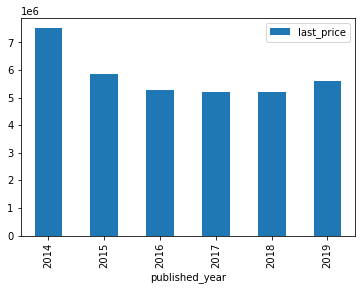

In [63]:
price_year = df.pivot_table(index = 'published_year', values = 'last_price').reset_index()
price_year.plot.bar(x='published_year', y='last_price')
plt.show()

Вывод: в 2014 стоимость была высокая, потому что был высокий спрос (спрос/предложение). Позже доллар возрос в стоимости, у людей стало меньше денег, санкции и прочие полические веяния могли повлиять на покупательную способность, что повлияло на резкое снижение цены.

**Посчитаем среднюю стоимость за квадратный метр в 10 топовых по количеству объявлений локаций**

In [64]:
#Сортируем по количеству объявлений и выводим
top_10 = df['locality_name'].value_counts().head(10)
top_10

Санкт-Петербург      14434
поселок Мурино         521
поселок Шушары         432
Всеволожск             387
Пушкин                 352
Колпино                337
поселок Парголово      322
Гатчина                304
деревня Кудрово        282
Выборг                 230
Name: locality_name, dtype: int64

Вывод: огромное количество объявлений в Санкт-Петербурге (в 30 раз больше объявлений в сравнении с вторым местом).

Расчитаем среднюю стоимость за квадратный метр в этих 10 населенных пунктах с большим количеством объявлений

In [65]:
#Создаем сводную таблицу 
top10_price = df.groupby('locality_name')['price_per_mtr'].agg(['count', 'mean'])
#Сортируем по количеству объявлений
top10_price = top10_price.sort_values('count', ascending=False).head(10)
#Меняем названия колонок для четкого понимания значений
top10_price.columns = ['Количество объявлений', 'Стоимость за метр']
top10_price

,Количество объявлений,Стоимость за метр
locality_name,,
Санкт-Петербург,14434,108358.604178
поселок Мурино,521,84911.266449
поселок Шушары,432,78315.148866
Всеволожск,387,67060.675039
Пушкин,352,101809.736108
Колпино,337,75333.295816
поселок Парголово,322,90448.423416
Гатчина,304,68781.726579
деревня Кудрово,282,92369.194787


Вывод: больше всего объявлений имеет Санкт-Петербург, не удивительно, крупный город и население в разы превосходит остальные населенные пункты.

Самый дорогой квадратный метр у Санкт-Петербурга

Самый дешевый квадратный метр у Выборга

**Опишем как стоимость жилья в Санкт-Петербурге меняется в зависимости от расстояния до центра**

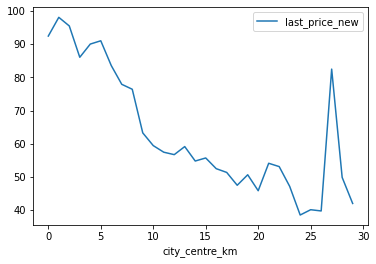

In [66]:
spb_centre_dist_km = df.query('locality_name == "Санкт-Петербург"')\
                     .pivot_table(index='city_centre_km', values='last_price_new', aggfunc= 'mean')\
                     .reset_index()
spb_centre_dist_km.plot.line(x='city_centre_km', y='last_price_new')
plt.show()

Вывод: видно по графику зависимость - чем дальше от центра, тем ниже стоимость. Опять же, неочевидно как определяли центр. Делаю предположение про резкий скачок в районе 27км - скорее всего это курортный район с элитным жильем.

### Напишите общий вывод

Проведена работа с целью определения факторов, влияющих на стоимость жилья. Ожидаемый вывод, что на стоимость жилья будет влиять большое количество факторов: как описание самого помещения, так и сторонние, например, политическая ситуация, которая сказывается на покупательной способности. 

Назовем черты помещений, которые более всего влияют на стоимость:
1. Площадь самого помещения (общая, жилая, кухня) - чем больше размер помещения, тем больше будет стоимость.
2. Чем больше комнат, тем больше стоимость жилья.
3. Квартиры, которые находятся между первым и последним этажом будут иметь выше стоимость.
4. Важную роль играет местоположение квартиры. Стоимость за квадратный метр будет выше всего в Петербурге, так же чем дальше от центра, тем квадрат будет дешеветь.

Типичная квартира для продажи будет иметь следующие характеристики:
1. Общую площадь 27-60 квадратных метров
2. Жилая зона иметь около 17 или около 30 квадратных метров, в зависимости от типа: однокомнатная квартира или студия
3. Размер кухни может быть разным, зависит от отдельной квартиры. Самые распространенные квартиры имеют от 7 до 10 квадратов
4. Стоимость квартиры будет колебаться в районе от 3 до 5 миллионов 
5. Количество комнат не больше 2х
6. Высота потолков около 2.6 метров
7. Квартира будет находится между первым и последним этажом
8. Количество этажей в доме будет либо 5, либо 9 
9. Отдаленность от центра ~16 километров 
10. Ближайший парк на расстоянии 400 метров